In [1]:
import sys
sys.path.append(r'C:\Users\Mechano_2\PycharmProjects\pro')
sys.path

['C:\\Users\\Mechano_2',
 'C:\\Users\\Mechano_2\\anaconda3\\envs\\final\\python37.zip',
 'C:\\Users\\Mechano_2\\anaconda3\\envs\\final\\DLLs',
 'C:\\Users\\Mechano_2\\anaconda3\\envs\\final\\lib',
 'C:\\Users\\Mechano_2\\anaconda3\\envs\\final',
 '',
 'C:\\Users\\Mechano_2\\anaconda3\\envs\\final\\lib\\site-packages',
 'C:\\Users\\Mechano_2\\anaconda3\\envs\\final\\lib\\site-packages\\win32',
 'C:\\Users\\Mechano_2\\anaconda3\\envs\\final\\lib\\site-packages\\win32\\lib',
 'C:\\Users\\Mechano_2\\anaconda3\\envs\\final\\lib\\site-packages\\Pythonwin',
 'C:\\Users\\Mechano_2\\anaconda3\\envs\\final\\lib\\site-packages\\IPython\\extensions',
 'C:\\Users\\Mechano_2\\.ipython',
 'C:\\Users\\Mechano_2\\PycharmProjects\\pro']

j_integral(kj/m^2): 45.659941695330346


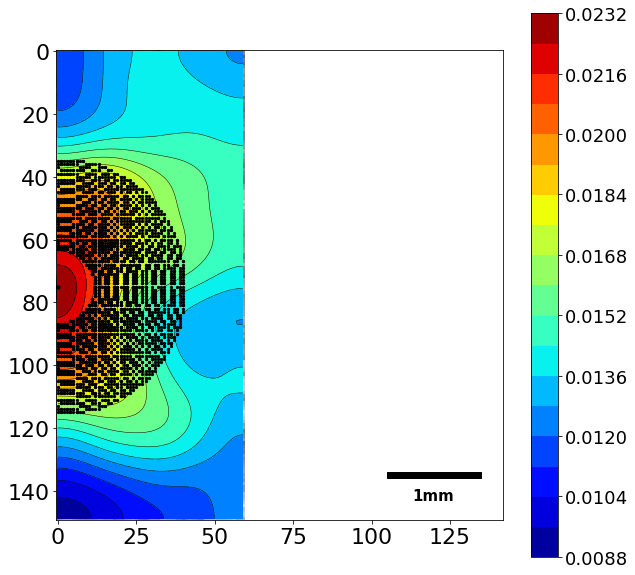

In [263]:
import mecha.DIC as dic
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mecha.fracture
import matplotlib.patches as patches
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

# Material property
n_hardening=17
yield_strength=535.435
poisson_ratio=0
alpha=0.585
In=2.78
youngs_modulus=71.7*1000
ml_slope=150

# Img parameter
contour_level = 20
ratio = 2/60
left, right, up_down = 0,60,75

# pick point
radius_gap = 1.5
gap_count = 21
start_gap = 0.4
path =r'E:\experiment data\aluminum\2021-03-30_cts\3_normal'
image = dic.load_file(path+'/img')
strain_hardening = np.array(pd.read_csv(path+'/HRR.csv', delim_whitespace=True))
eps_rr, eps_tt, eps_rt = strain_hardening[:,1], strain_hardening[:,2] ,strain_hardening[:,3]
strain_bar = np.sqrt(4* (np.power(eps_rr,2) + np.power(eps_tt,2) - eps_rr*eps_tt + 3 * np.power(eps_rt,2)) /9)
strain_hardening = np.hstack((strain_hardening[:,0].reshape(-1,1),strain_bar.reshape(-1,1)))

crack_tip = [[400,207],[397,210],[389,205],[387,202],[386,200]] # y, x

i = 0 ##ref
j = 3 #cur

ref = list(image.keys())[i]
cur = list(image.keys())[j]
src_reference = image[ref][:,:,1][crack_tip[i][0]-up_down:crack_tip[i][0]+up_down,crack_tip[i][1]-left:crack_tip[i][1]+right]
src_current = image[cur][:,:,1][crack_tip[j][0]-up_down:crack_tip[j][0]+up_down,crack_tip[j][1]-left:crack_tip[j][1]+right]

# src_reference = cv2.GaussianBlur(src_reference,(0,0),10)
# src_current = cv2.GaussianBlur(src_current,(0,0),10)

dst = cv2.subtract(src_current.astype('float64'),src_reference.astype('float64'))
dst = dst.astype(float)
dst = np.where(dst>10, dst*0, dst)
dst = np.where(dst<0, dst*0, dst)
gas=dic.pool2d(dst,10,1,'max')
gas = cv2.GaussianBlur(dst,(0,0),10)

max_crack_tip = [left,up_down]

count = 0
radius_g = 0
location = []
for _ in range(1, gap_count):
    if count == 0:
        location = dic.circle_location(start_gap/ratio, ratio,90,0)
        radius_g += radius_gap
        count += 1
    else:
        location = np.vstack((location, dic.circle_location(start_gap/ratio+radius_g, ratio,90,0)))
        radius_g += radius_gap

df = pd.DataFrame(location, columns=['x', 'y', 'angle', 'r'])
df.x = df.x + max_crack_tip[0]
df.y = df.y + max_crack_tip[1]
df.r = df.r*0.001

hardening_plus=np.vstack((strain_hardening[:,0],strain_hardening[:,1])).transpose()
hardening_minus = np.flip(np.vstack((strain_hardening[:,0]*-1,strain_hardening[:,1])).transpose(), axis=0)
hardening = np.vstack((hardening_minus, hardening_plus))

ml=[]
effective_strain=[]
theta_list = []

for y,x,theta in np.array(df[['y','x','angle']]):
    current_ml = gas[np.round(y).astype(int),np.round(x).astype(int)]
    ml = np.append(ml, current_ml)
    effective_strain = np.append(effective_strain, current_ml/ml_slope)
    theta_list = np.append(theta_list, hardening[find_nearest(hardening[:,0],theta),1])

df['ml'] = ml
df['effective_strain'] = effective_strain
df['hardening_strain_bar'] = theta_list

plastic_k = np.power(df.effective_strain * youngs_modulus
                     / (df.hardening_strain_bar * alpha * yield_strength *
                        np.power(df.r, (-1 * n_hardening/(n_hardening+1)))), 1/n_hardening)
j_integral = (np.power(plastic_k.mean(),(n_hardening+1)) * alpha * yield_strength**2 * In)/ youngs_modulus


print('j_integral(kj/m^2):', 1000*j_integral)
plt.rcParams.update({'font.size': 22})
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(src_current, cmap='gray')
# plt.axis('off')
csf = ax.contourf(gas/150, contour_level, cmap = 'jet')
CS = ax.contour(gas/150, contour_level, colors='black', linewidths = 0.5)
cbar= plt.colorbar(csf)
cbar.ax.tick_params(labelsize=18)
plt.scatter(left, up_down, s = 10,  c = 'black')
plt.scatter(df.x, df.y, s = 5,  c='black')
ax.add_patch(
     patches.Rectangle(
        (105, 134),
        30,
        2,
        edgecolor = 'black',
        facecolor = 'black',
        fill=True
     ) )
plt.text( 113,143, '1mm', fontsize=15, fontweight='bold')
plt.savefig(path+'/{}_basic.png'.(j), dpi=300,bbox_inches='tight')
plt.show()
plt.close()

<ipython-input-245-17dfdce3dd02>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(labels)


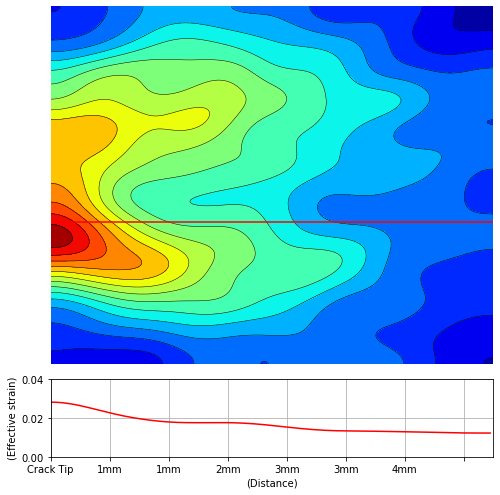

In [245]:
import pickle
import cv2

from matplotlib.gridspec import GridSpec
plt.rcParams.update({'font.size': 10})
ee_resize = gas
fig = plt.figure(figsize=(10, 10))
gs = GridSpec(nrows=6, ncols=5)
contour_level = 17
ax0 = fig.add_subplot(gs[0:4, 0:4])
csf = ax0.contourf(gas/150, contour_level, cmap = 'jet')
CS = ax0.contour(gas/150, contour_level, colors='black', linewidths = 0.5)
# ax0.vlines(50,0,np.shape(ee_resize)[0]-1, color='black', linestyles='-.')
ax0.hlines(75,0,np.shape(ee_resize)[1]-1, color='red')
plt.gca().invert_yaxis()
ax0.axis('off')


profile_strain=gas[75,:]/ml_slope
ax2 = fig.add_subplot(gs[4, 0:4])
ax2.plot(profile_strain, color='red')

# ax2.vlines(50,0,3.5, color='black', linestyles='-.')
ax2.set_ylim(0,0.04)
ax2.set_xlim(0,right)
plt.grid()

labels = [item.get_text() for item in ax2.get_xticklabels()]
labels[0] = 'Crack Tip'
for i in range(1,7):
    labels[i] = str(round(20*i*ratio))+'mm'
ax2.set_ylabel('(Effective strain)')
ax2.set_xlabel('(Distance)')
ax2.set_xticklabels(labels)


plt.savefig(path+'/ml_profile.png', dpi= 300,bbox_inches='tight')

In [ ]:
left_cut = 90
rigt_cut = -300
up_down_cut = 200
fig,ax = plt.subplots(1,2)

ax[0].imshow(image['ff0870'][up_down_cut:-up_down_cut,left_cut:rigt_cut])
ax[0].scatter(crack_tip[0][1]-left_cut,crack_tip[0][0]-up_down_cut,c='red')
ax[0].add_patch(
     patches.Rectangle(
        (crack_tip[0][1]-left-left_cut, crack_tip[0][1]+up_down-up_down_cut),
        right+left,
        up_down*2,
        edgecolor = 'red',
        facecolor = 'black',
        fill=False, lw=3, ls=':'
     ) )
ax[0].axis('off')

ax[1].imshow(image['ff3569'][up_down_cut:-up_down_cut,left_cut:rigt_cut])
ax[1].scatter(crack_tip[-1][1]-left_cut,crack_tip[-1][0]-up_down_cut,c='red')
ax[1].add_patch(
     patches.Rectangle(
        (crack_tip[-1][1]-left-left_cut, crack_tip[-1][1]+up_down-up_down_cut),
        right+left,
        up_down*2,
        edgecolor = 'red',
        facecolor = 'black',
        fill=False, lw=3, ls=':'
     ) )
ax[1].axis('off')

plt.savefig(r'E:\사진/겹d치기%d.png'%j,dpi=300,bbox_inches='tight')

Save Done


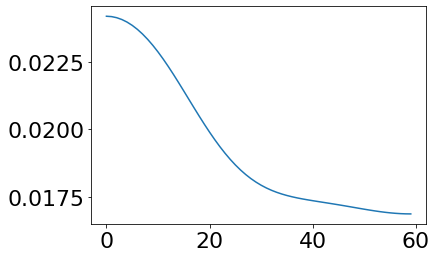

In [261]:
""""""
import pickle
plt.plot(gas[75,:]/150)
with open(path+r'/ml_line.pkl','wb') as f:
    pickle.dump(gas, f)

print('Save Done')